In [1]:
!pip install imbalanced-learn # Install the library using pip

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/accepted_2007_to_2018Q4.csv')

<ipython-input-2-45092040c8ae>:11: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/accepted_2007_to_2018Q4.csv')


In [3]:
import gc
import warnings
warnings.filterwarnings('ignore')

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        # print(col, col_type)
        if col_type != ('object' or 'category'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    gc.collect()
    return df

In [5]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1642.35 MB
Memory usage after optimization is: 527.04 MB
Decreased by 67.9%


In [6]:
df = df[df["last_pymnt_d"].str.contains("2019").fillna(False)]
df.shape

(584120, 151)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 584120 entries, 0 to 1425605
Columns: 151 entries, id to settlement_term
dtypes: category(38), float16(96), float32(16), float64(1)
memory usage: 277.9 MB


In [8]:
df.isnull().sum()

,0
id,0
member_id,584120
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
...,...
settlement_status,582950
settlement_date,582950
settlement_amount,582950
settlement_percentage,582950


In [9]:
# Check if the required columns exist in the dataset
if 'installment' in df.columns and 'annual_inc' in df.columns:
    # Generate the new feature 'installment_feat'
    # We assume that the borrower's monthly income is annual income divided by 12
    df['installment_feat'] = df['installment'] / (df['annual_inc'] / 12)
else:
    print("Required columns 'installment' or 'annual_inc' not found in the dataset.")

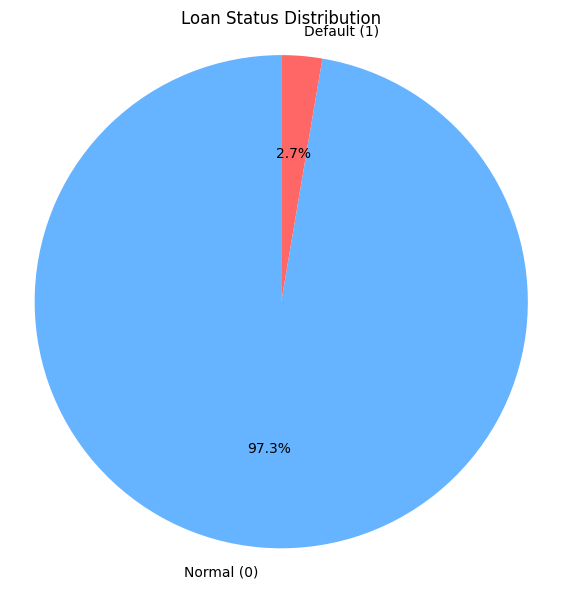

In [10]:
# Define the encoding for loan status
normal_status = ['Current', 'Fully Paid', 'Issued']
default_status = ['Default', 'Charged Off', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']

# Check if the 'loan_status' column exists in the dataset
if 'loan_status' in df.columns:
    # Encode the loan status
    df['loan_status_encoded'] = df['loan_status'].apply(
        lambda x: 0 if x in normal_status else (1 if x in default_status else None)
    )

    # Drop rows where 'loan_status' couldn't be encoded
    df1 = df.dropna(subset=['loan_status_encoded'])

    # Count the occurrences of each status
    status_counts = df['loan_status_encoded'].value_counts()

    # Plot the pie chart
    labels = ['Normal (0)', 'Default (1)']
    plt.figure(figsize=(7, 7))
    plt.pie(status_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
    plt.title('Loan Status Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

else:
    print("The column 'loan_status' is not found in the dataset.")

# Conclusion :

> We find that the dataset is highly imbalanced.



In [11]:
# Abstract emp_length
def emp_length_to_numeric(emp_length):
    if pd.isnull(emp_length):
        return None
    emp_length = emp_length.strip()
    if emp_length == '10+ years':
        return 10
    elif emp_length == '< 1 year':
        return 0
    elif emp_length == 'n/a':
        return None
    else:
        return int(emp_length.split()[0])  # Extract the number from the text

if 'emp_length' in df.columns:
    df['emp_length_numeric'] = df['emp_length'].apply(emp_length_to_numeric)
else:
    print("The column 'emp_length' is not found in the dataset.")

# Abstract grade
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

if 'grade' in df.columns:
    df['grade_numeric'] = df['grade'].map(grade_mapping)
else:
    print("The column 'grade' is not found in the dataset.")

In [12]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,installment_feat,loan_status_encoded,emp_length_numeric,grade_numeric
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.992188,123.000,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.026836,0,10,3
3,66310712,NaN,35008.0,35008.0,35008.0,60 months,14.851562,830.000,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.090545,0,10,3
10,68356421,NaN,22400.0,22400.0,22400.0,60 months,12.882812,508.250,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.064200,0,6,3
11,68426545,NaN,16000.0,16000.0,16000.0,60 months,12.882812,363.000,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.062229,0,1,3
18,68506798,NaN,23008.0,23008.0,23008.0,60 months,8.492188,471.750,B,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.088453,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425601,143210393,NaN,7500.0,7500.0,7500.0,36 months,11.796875,248.375,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.054191,0,3,2
1425602,143157626,NaN,8000.0,8000.0,8000.0,36 months,8.812500,253.750,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,0.077481,0,NaN,1
1425603,142927273,NaN,10000.0,10000.0,10000.0,36 months,7.839844,312.750,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.089003,0,1,1
1425604,143193011,NaN,8000.0,8000.0,8000.0,36 months,19.921875,297.000,D,D3,...,NaN,NaN,NaN,NaN,NaN,NaN,0.052473,0,1,4


In [13]:
# Display only columns 'A' and 'C'
selected_columns = df[['loan_amnt', 'funded_amnt','funded_amnt_inv','installment','grade','open_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','open_act_il','delinq_amnt','num_op_rev_tl','home_ownership','verification_status','application_type','purpose','term']]
selected_columns


,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,open_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,open_act_il,delinq_amnt,num_op_rev_tl,home_ownership,verification_status,application_type,purpose,term
0,3600.0,3600.0,3600.0,123.000,C,7.0,0.0,0.0,4420.0,4420.0,3600.0,821.500,2.0,0.0,4.0,MORTGAGE,Not Verified,Individual,debt_consolidation,36 months
3,35008.0,35008.0,35008.0,830.000,C,13.0,15896.0,15896.0,31472.0,31472.0,19104.0,12360.000,1.0,0.0,10.0,MORTGAGE,Source Verified,Individual,debt_consolidation,60 months
10,22400.0,22400.0,22400.0,508.250,C,16.0,9912.0,9912.0,19280.0,19280.0,12488.0,6788.000,5.0,0.0,10.0,MORTGAGE,Not Verified,Individual,debt_consolidation,60 months
11,16000.0,16000.0,16000.0,363.000,C,13.0,7080.0,7080.0,13768.0,13768.0,8920.0,4848.000,2.0,0.0,10.0,MORTGAGE,Not Verified,Individual,debt_consolidation,60 months
18,23008.0,23008.0,23008.0,471.750,B,21.0,9584.0,9584.0,17904.0,17904.0,13416.0,4480.000,7.0,0.0,14.0,RENT,Not Verified,Individual,credit_card,60 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425601,7500.0,7500.0,7500.0,248.375,B,9.0,6792.0,6792.0,1009.0,1009.0,709.0,300.250,5.0,0.0,4.0,RENT,Not Verified,Individual,credit_card,36 months
1425602,8000.0,8000.0,8000.0,253.750,A,5.0,7212.0,7212.0,1011.0,1011.0,788.5,222.375,0.0,0.0,4.0,MORTGAGE,Not Verified,Individual,debt_consolidation,36 months
1425603,10000.0,10000.0,10000.0,312.750,A,9.0,9000.0,9000.0,1269.0,1269.0,999.0,270.500,6.0,0.0,3.0,RENT,Source Verified,Individual,credit_card,36 months
1425604,8000.0,8000.0,8000.0,297.000,D,15.0,7328.0,7328.0,1179.0,1179.0,673.5,505.750,3.0,0.0,12.0,RENT,Source Verified,Individual,moving,36 months


In [14]:
selected_columns = selected_columns.drop_duplicates()
selected_columns = selected_columns.dropna()

selected_columns

,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,open_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,open_act_il,delinq_amnt,num_op_rev_tl,home_ownership,verification_status,application_type,purpose,term
0,3600.0,3600.0,3600.0,123.000,C,7.0,0.0,0.0,4420.0,4420.0,3600.0,821.500,2.0,0.0,4.0,MORTGAGE,Not Verified,Individual,debt_consolidation,36 months
3,35008.0,35008.0,35008.0,830.000,C,13.0,15896.0,15896.0,31472.0,31472.0,19104.0,12360.000,1.0,0.0,10.0,MORTGAGE,Source Verified,Individual,debt_consolidation,60 months
10,22400.0,22400.0,22400.0,508.250,C,16.0,9912.0,9912.0,19280.0,19280.0,12488.0,6788.000,5.0,0.0,10.0,MORTGAGE,Not Verified,Individual,debt_consolidation,60 months
11,16000.0,16000.0,16000.0,363.000,C,13.0,7080.0,7080.0,13768.0,13768.0,8920.0,4848.000,2.0,0.0,10.0,MORTGAGE,Not Verified,Individual,debt_consolidation,60 months
18,23008.0,23008.0,23008.0,471.750,B,21.0,9584.0,9584.0,17904.0,17904.0,13416.0,4480.000,7.0,0.0,14.0,RENT,Not Verified,Individual,credit_card,60 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425601,7500.0,7500.0,7500.0,248.375,B,9.0,6792.0,6792.0,1009.0,1009.0,709.0,300.250,5.0,0.0,4.0,RENT,Not Verified,Individual,credit_card,36 months
1425602,8000.0,8000.0,8000.0,253.750,A,5.0,7212.0,7212.0,1011.0,1011.0,788.5,222.375,0.0,0.0,4.0,MORTGAGE,Not Verified,Individual,debt_consolidation,36 months
1425603,10000.0,10000.0,10000.0,312.750,A,9.0,9000.0,9000.0,1269.0,1269.0,999.0,270.500,6.0,0.0,3.0,RENT,Source Verified,Individual,credit_card,36 months
1425604,8000.0,8000.0,8000.0,297.000,D,15.0,7328.0,7328.0,1179.0,1179.0,673.5,505.750,3.0,0.0,12.0,RENT,Source Verified,Individual,moving,36 months


In [15]:
df1 = selected_columns

In [16]:
df1

,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,open_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,open_act_il,delinq_amnt,num_op_rev_tl,home_ownership,verification_status,application_type,purpose,term
0,3600.0,3600.0,3600.0,123.000,C,7.0,0.0,0.0,4420.0,4420.0,3600.0,821.500,2.0,0.0,4.0,MORTGAGE,Not Verified,Individual,debt_consolidation,36 months
3,35008.0,35008.0,35008.0,830.000,C,13.0,15896.0,15896.0,31472.0,31472.0,19104.0,12360.000,1.0,0.0,10.0,MORTGAGE,Source Verified,Individual,debt_consolidation,60 months
10,22400.0,22400.0,22400.0,508.250,C,16.0,9912.0,9912.0,19280.0,19280.0,12488.0,6788.000,5.0,0.0,10.0,MORTGAGE,Not Verified,Individual,debt_consolidation,60 months
11,16000.0,16000.0,16000.0,363.000,C,13.0,7080.0,7080.0,13768.0,13768.0,8920.0,4848.000,2.0,0.0,10.0,MORTGAGE,Not Verified,Individual,debt_consolidation,60 months
18,23008.0,23008.0,23008.0,471.750,B,21.0,9584.0,9584.0,17904.0,17904.0,13416.0,4480.000,7.0,0.0,14.0,RENT,Not Verified,Individual,credit_card,60 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425601,7500.0,7500.0,7500.0,248.375,B,9.0,6792.0,6792.0,1009.0,1009.0,709.0,300.250,5.0,0.0,4.0,RENT,Not Verified,Individual,credit_card,36 months
1425602,8000.0,8000.0,8000.0,253.750,A,5.0,7212.0,7212.0,1011.0,1011.0,788.5,222.375,0.0,0.0,4.0,MORTGAGE,Not Verified,Individual,debt_consolidation,36 months
1425603,10000.0,10000.0,10000.0,312.750,A,9.0,9000.0,9000.0,1269.0,1269.0,999.0,270.500,6.0,0.0,3.0,RENT,Source Verified,Individual,credit_card,36 months
1425604,8000.0,8000.0,8000.0,297.000,D,15.0,7328.0,7328.0,1179.0,1179.0,673.5,505.750,3.0,0.0,12.0,RENT,Source Verified,Individual,moving,36 months


In [17]:
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['home_ownership_ANY'] = df1['home_ownership'].apply(lambda x: 1 if x == 'ANY' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['home_ownership_MORTGAGE'] = df1['home_ownership'].apply(lambda x: 1 if x == 'MORTGAGE' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['home_ownership_OWN'] = df1['home_ownership'].apply(lambda x: 1 if x == 'OWN' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['home_ownership_RENT'] = df1['home_ownership'].apply(lambda x: 1 if x == 'RENT' else 0)

df1.drop('home_ownership', axis=1, inplace=True)

In [18]:
df1

,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,open_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,delinq_amnt,num_op_rev_tl,verification_status,application_type,purpose,term,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,3600.0,3600.0,3600.0,123.000,C,7.0,0.0,0.0,4420.0,4420.0,...,0.0,4.0,Not Verified,Individual,debt_consolidation,36 months,0,1,0,0
3,35008.0,35008.0,35008.0,830.000,C,13.0,15896.0,15896.0,31472.0,31472.0,...,0.0,10.0,Source Verified,Individual,debt_consolidation,60 months,0,1,0,0
10,22400.0,22400.0,22400.0,508.250,C,16.0,9912.0,9912.0,19280.0,19280.0,...,0.0,10.0,Not Verified,Individual,debt_consolidation,60 months,0,1,0,0
11,16000.0,16000.0,16000.0,363.000,C,13.0,7080.0,7080.0,13768.0,13768.0,...,0.0,10.0,Not Verified,Individual,debt_consolidation,60 months,0,1,0,0
18,23008.0,23008.0,23008.0,471.750,B,21.0,9584.0,9584.0,17904.0,17904.0,...,0.0,14.0,Not Verified,Individual,credit_card,60 months,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425601,7500.0,7500.0,7500.0,248.375,B,9.0,6792.0,6792.0,1009.0,1009.0,...,0.0,4.0,Not Verified,Individual,credit_card,36 months,0,0,0,1
1425602,8000.0,8000.0,8000.0,253.750,A,5.0,7212.0,7212.0,1011.0,1011.0,...,0.0,4.0,Not Verified,Individual,debt_consolidation,36 months,0,1,0,0
1425603,10000.0,10000.0,10000.0,312.750,A,9.0,9000.0,9000.0,1269.0,1269.0,...,0.0,3.0,Source Verified,Individual,credit_card,36 months,0,0,0,1
1425604,8000.0,8000.0,8000.0,297.000,D,15.0,7328.0,7328.0,1179.0,1179.0,...,0.0,12.0,Source Verified,Individual,moving,36 months,0,0,0,1


In [19]:
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['verification_status_Not Verified'] = df1['verification_status'].apply(lambda x: 1 if x == 'Not Verified' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['verification_status_Source Verified'] = df1['verification_status'].apply(lambda x: 1 if x == 'Source Verified' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['verification_status_Verified'] = df1['verification_status'].apply(lambda x: 1 if x == 'Verified' else 0)

df1.drop('verification_status', axis=1, inplace=True)

In [20]:
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['application_type_Individual'] = df1['application_type'].apply(lambda x: 1 if x == 'Individual' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['application_type_Joint App'] = df1['application_type'].apply(lambda x: 1 if x == 'Joint App' else 0)

df1.drop('application_type', axis=1, inplace=True)

In [21]:
import pandas as pd
# Get the count of each unique value in the 'home_ownership' column
value_counts = df['purpose'].value_counts()

# Print the counts
print(value_counts)

purpose
debt_consolidation    322479
credit_card           143926
home_improvement       39677
other                  35659
major_purchase         12732
medical                 7223
car                     5711
small_business          5420
vacation                3930
moving                  3577
house                   3487
renewable_energy         295
wedding                    4
educational                0
Name: count, dtype: int64


In [22]:
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['purpose_major_purchase'] = df1['purpose'].apply(lambda x: 1 if x == 'major purchase' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['purpose_renewable_energy'] = df1['purpose'].apply(lambda x: 1 if x == 'renewable energy' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['purpose_small_business'] = df1['purpose'].apply(lambda x: 1 if x == 'small business' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['purpose_vacation'] = df1['purpose'].apply(lambda x: 1 if x == 'vacation' else 0)

df1.drop('purpose', axis=1, inplace=True)

In [23]:
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['term_36_months'] = df1['term'].apply(lambda x: 1 if x == '36 months' else 0)
# Create new column 'home_ownership_RENT', where 1 if 'RENT', otherwise 0
df1['term_60_months'] = df1['term'].apply(lambda x: 1 if x == '60 months' else 0)

df1.drop('term', axis=1, inplace=True)

In [24]:
df1.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'grade',
       'open_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'open_act_il',
       'delinq_amnt', 'num_op_rev_tl', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_Individual', 'application_type_Joint App',
       'purpose_major_purchase', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'term_36_months',
       'term_60_months'],
      dtype='object')

In [25]:
df1['loan_status']=df['loan_status']

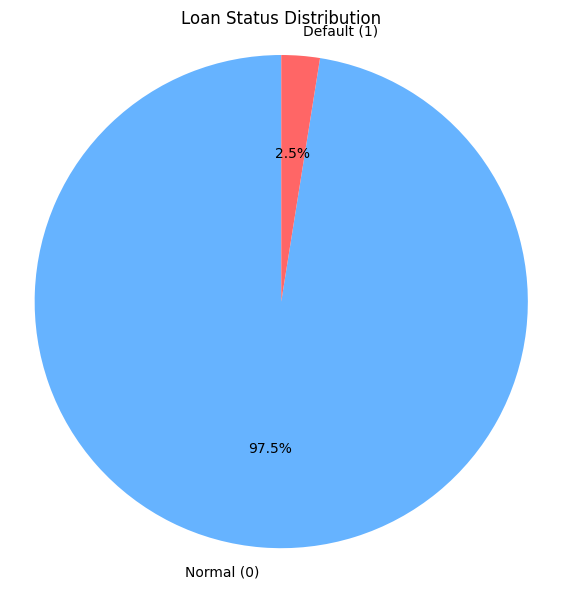

In [26]:
# Define the encoding for loan status
normal_status = ['Current', 'Fully Paid', 'Issued']
default_status = ['Default', 'Charged Off', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']

# Check if the 'loan_status' column exists in the dataset
if 'loan_status' in df1.columns:
    # Encode the loan status
    df1['loan_status_encoded'] = df1['loan_status'].apply(
        lambda x: 0 if x in normal_status else (1 if x in default_status else None)
    )

    # Drop rows where 'loan_status' couldn't be encoded
    df1 = df1.dropna(subset=['loan_status_encoded'])

    # Count the occurrences of each status
    status_counts = df1['loan_status_encoded'].value_counts()

    # Plot the pie chart
    labels = ['Normal (0)', 'Default (1)']
    plt.figure(figsize=(7, 7))
    plt.pie(status_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
    plt.title('Loan Status Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

else:
    print("The column 'loan_status' is not found in the dataset.")

In [27]:
df1

,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,open_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,application_type_Individual,application_type_Joint App,purpose_major_purchase,purpose_renewable_energy,purpose_small_business,purpose_vacation,term_36_months,term_60_months,loan_status,loan_status_encoded
0,3600.0,3600.0,3600.0,123.000,C,7.0,0.0,0.0,4420.0,4420.0,...,1,0,0,0,0,0,0,0,Fully Paid,0
3,35008.0,35008.0,35008.0,830.000,C,13.0,15896.0,15896.0,31472.0,31472.0,...,1,0,0,0,0,0,0,0,Current,0
10,22400.0,22400.0,22400.0,508.250,C,16.0,9912.0,9912.0,19280.0,19280.0,...,1,0,0,0,0,0,0,0,Current,0
11,16000.0,16000.0,16000.0,363.000,C,13.0,7080.0,7080.0,13768.0,13768.0,...,1,0,0,0,0,0,0,0,Current,0
18,23008.0,23008.0,23008.0,471.750,B,21.0,9584.0,9584.0,17904.0,17904.0,...,1,0,0,0,0,0,0,0,Current,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425601,7500.0,7500.0,7500.0,248.375,B,9.0,6792.0,6792.0,1009.0,1009.0,...,1,0,0,0,0,0,0,0,Current,0
1425602,8000.0,8000.0,8000.0,253.750,A,5.0,7212.0,7212.0,1011.0,1011.0,...,1,0,0,0,0,0,0,0,Current,0
1425603,10000.0,10000.0,10000.0,312.750,A,9.0,9000.0,9000.0,1269.0,1269.0,...,1,0,0,0,0,0,0,0,Current,0
1425604,8000.0,8000.0,8000.0,297.000,D,15.0,7328.0,7328.0,1179.0,1179.0,...,1,0,0,0,0,0,0,0,Current,0


In [30]:
df12 = df1.head(10000)

In [31]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import numpy as np

# Step 4: Separate features (X) and target (y)
X = df12.drop(columns=['loan_status_encoded'])
y = df12['loan_status_encoded']

# Step 5: Perform Recursive Feature Elimination (RFE) with a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ----> Convert string values to numerical representations if necessary
# Identify columns with object (string) dtype
object_columns = X.select_dtypes(include=['object']).columns

# ----> Convert string values to numerical representations if necessary
# Identify columns with object (string) dtype or those containing non-numeric values
# Iterate through columns and check data type or values
for column in X.columns:
    # Check if column contains any non-numeric values
    if X[column].apply(lambda x: pd.api.types.is_string_dtype(type(x)) or (pd.api.types.is_numeric_dtype(type(x)) and pd.isnull(pd.to_numeric(x, errors='coerce')))).any():
        # If non-numeric values exist, perform one-hot encoding
        X = pd.get_dummies(X, columns=[column], drop_first=True, dummy_na=False) # dummy_na=False to prevent creating a separate category for NaN

# ----> Replace infinite values with a large finite number
X = X.replace([np.inf, -np.inf], np.nan)  # replace inf with NaN

# ----> Modified: Iterate over columns and fill NaN with max only for numeric columns
for column in X.columns:
    if pd.api.types.is_numeric_dtype(X[column]):
        X[column] = X[column].fillna(X[column].max())
    else:
        # For categorical columns, you can fill with the most frequent category
        # or a specific category like 'Unknown' if applicable
        X[column] = X[column].fillna(X[column].mode()[0])
        #This handles the unordered categorical columns

# We want to select the top 30 features
rfe = RFE(clf, n_features_to_select=30)
rfe.fit(X, y)

# Step 6: Get the selected features
selected_features = X.columns[rfe.support_]
print("Top 30 features selected by RFE:")
print(selected_features)

Top 30 features selected by RFE:
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'open_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'open_act_il',
       'num_op_rev_tl', 'home_ownership_MORTGAGE', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_Individual', 'application_type_Joint App', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'loan_status_Current',
       'loan_status_Fully Paid', 'loan_status_In Grace Period',
       'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)'],
      dtype='object')


In [32]:
import seaborn as sns
import pandas as pd

# Step 1: Generate the Pearson correlation matrix for the top 30 features
# ----> Select only the numerical features from selected_features
# ----> Ensure selected_features are present in the DataFrame's columns
# Get the intersection of selected_features and df's columns
common_features = list(set(selected_features) & set(df12.columns))

# Select only numerical features from the common features
numerical_selected_features = df12[common_features].select_dtypes(include=['number']).columns

# ----> Calculate correlation only for numerical features
correlation_matrix = df12[numerical_selected_features].corr().loc[
    numerical_selected_features, numerical_selected_features
]

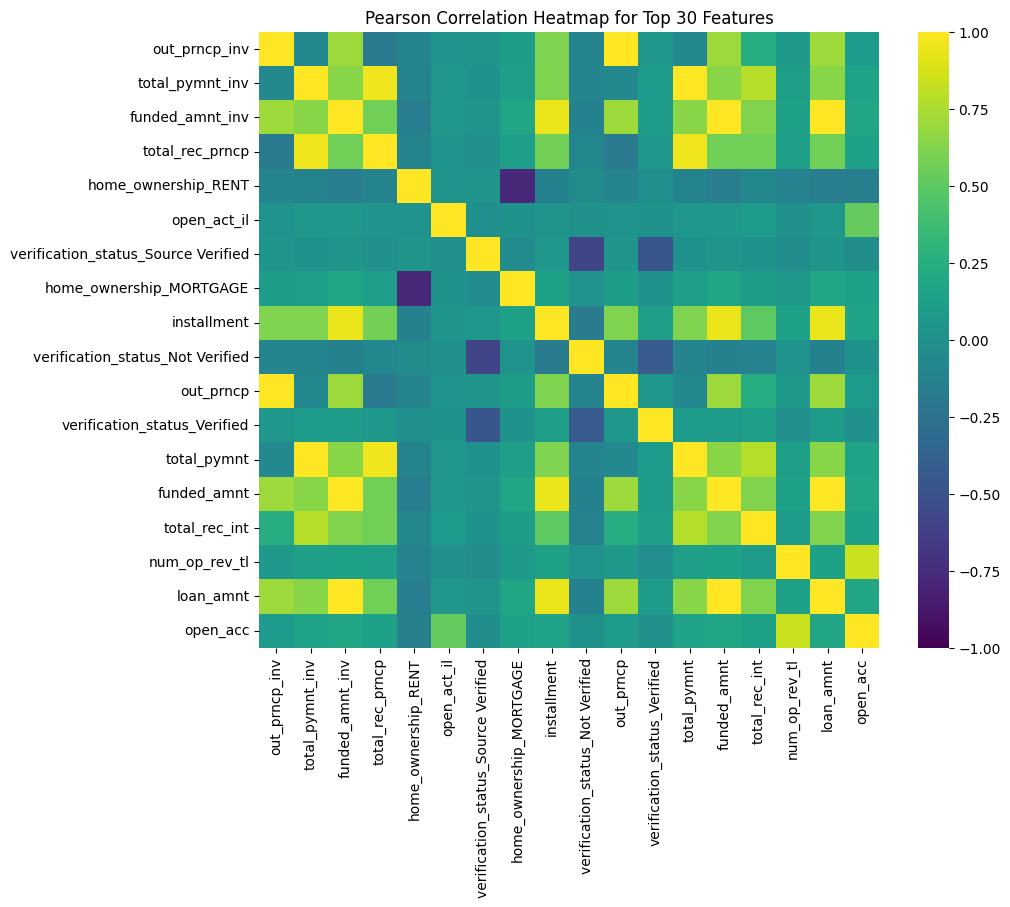

In [33]:
# Step 2: Visualize the Pearson correlation matrix using a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', vmin = -1, vmax = 1, center = 0)
plt.title("Pearson Correlation Heatmap for Top 30 Features")
plt.show()

In [34]:
# Step 3: Identify and remove highly correlated features
# We will set a correlation threshold of 0.80 (you can adjust this)
threshold = 0.70

columns_to_correlate = ['loan_amnt', 'installment', 'grade', 'open_acc', 'total_pymnt', 'total_rec_int', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'verification_status_Not Verified','application_type_Individual', 'purpose_major_purchase' , 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation' , 'term_36_months']
# Create an empty set to store features to drop
columns_to_drop = set()

# Iterate through the correlation matrix and mark highly correlated features
for i in range(len(df12.columns)):
    for j in range(i):
        if df12.columns[i] not in columns_to_correlate:  # If correlation is above the threshold
            columns_to_drop.add(df12.columns[i])

# Drop the highly correlated features to reduce dimensions to 15 features
reduced_data = df12.drop(columns=list(columns_to_drop))


# Step 4: Display the final 15 features
print("Selected 15 features after dimension reduction:")
print(reduced_data.columns)

Selected 15 features after dimension reduction:
Index(['loan_amnt', 'installment', 'grade', 'open_acc', 'total_pymnt',
       'total_rec_int', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
       'verification_status_Not Verified', 'application_type_Individual',
       'purpose_major_purchase', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'term_36_months'],
      dtype='object')


In [35]:
# Abstract grade
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

if 'grade' in reduced_data.columns:
    reduced_data['grade'] = reduced_data['grade'].map(grade_mapping)

In [36]:
# Import necessary library
import numpy as np

# Floor the float values and convert them to integers for numerical columns only
numerical_columns = reduced_data.select_dtypes(include=np.number).columns
reduced_data[numerical_columns] = reduced_data[numerical_columns].apply(np.floor).astype(int)

In [37]:
reduced_data

,loan_amnt,installment,grade,open_acc,total_pymnt,total_rec_int,home_ownership_ANY,home_ownership_MORTGAGE,verification_status_Not Verified,application_type_Individual,purpose_major_purchase,purpose_renewable_energy,purpose_small_business,purpose_vacation,term_36_months
0,3600,123,3,7,4420,821,0,1,1,1,0,0,0,0,0
3,35008,830,3,13,31472,12360,0,1,0,1,0,0,0,0,0
10,22400,508,3,16,19280,6788,0,1,1,1,0,0,0,0,0
11,16000,363,3,13,13768,4848,0,1,1,1,0,0,0,0,0
18,23008,471,2,21,17904,4480,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427562,24992,576,3,10,6896,3150,0,1,0,1,0,0,0,0,0
427563,10000,233,3,14,2788,1306,0,0,0,1,0,0,0,0,0
427564,16992,517,1,5,6208,879,0,1,0,1,0,0,0,0,0
427565,5000,163,2,9,1958,469,0,0,0,1,0,0,0,0,0


In [38]:
# Generate the Pearson correlation matrix for the 15 features
# Ensure all columns in reduced_data are present in X
common_cols = list(set(reduced_data.columns) & set(X.columns))

# Select only numeric columns from common_cols
numeric_common_cols = X[common_cols].select_dtypes(include=np.number).columns.tolist()

# Calculate correlation for numeric common columns only
correlation_matrix1 = X[numeric_common_cols].corr().loc[numeric_common_cols, numeric_common_cols]

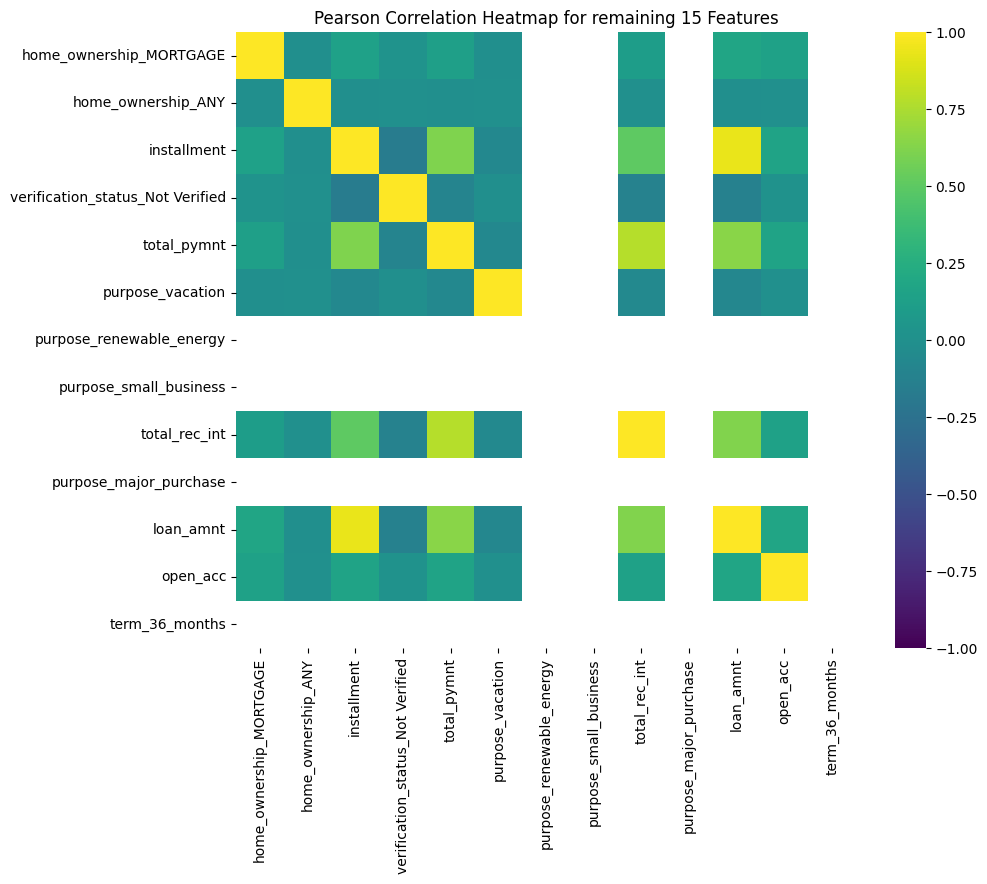

In [39]:
# Step 2: Visualize the Pearson correlation matrix using a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix1, annot=False, cmap='viridis', vmin = -1, vmax = 1, center = 0)
plt.title("Pearson Correlation Heatmap for remaining 15 Features")
plt.show()

In [40]:
df12

,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,open_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,application_type_Individual,application_type_Joint App,purpose_major_purchase,purpose_renewable_energy,purpose_small_business,purpose_vacation,term_36_months,term_60_months,loan_status,loan_status_encoded
0,3600.0,3600.0,3600.0,123.00,C,7.0,0.0,0.0,4420.0,4420.0,...,1,0,0,0,0,0,0,0,Fully Paid,0
3,35008.0,35008.0,35008.0,830.00,C,13.0,15896.0,15896.0,31472.0,31472.0,...,1,0,0,0,0,0,0,0,Current,0
10,22400.0,22400.0,22400.0,508.25,C,16.0,9912.0,9912.0,19280.0,19280.0,...,1,0,0,0,0,0,0,0,Current,0
11,16000.0,16000.0,16000.0,363.00,C,13.0,7080.0,7080.0,13768.0,13768.0,...,1,0,0,0,0,0,0,0,Current,0
18,23008.0,23008.0,23008.0,471.75,B,21.0,9584.0,9584.0,17904.0,17904.0,...,1,0,0,0,0,0,0,0,Current,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427562,24992.0,24992.0,24992.0,576.50,C,10.0,21248.0,21248.0,6896.0,6896.0,...,1,0,0,0,0,0,0,0,Current,0
427563,10000.0,10000.0,10000.0,233.00,C,14.0,8520.0,8520.0,2788.0,2788.0,...,1,0,0,0,0,0,0,0,Current,0
427564,16992.0,16992.0,16992.0,517.50,A,5.0,11672.0,11672.0,6208.0,6208.0,...,1,0,0,0,0,0,0,0,Current,0
427565,5000.0,5000.0,5000.0,163.50,B,9.0,3510.0,3510.0,1958.0,1958.0,...,1,0,0,0,0,0,0,0,Current,0


In [41]:
# Abstract grade
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

if 'grade' in df12.columns:
    df12['grade'] = df12['grade'].map(grade_mapping)
else:
    print("The column 'grade' is not found in the dataset.")

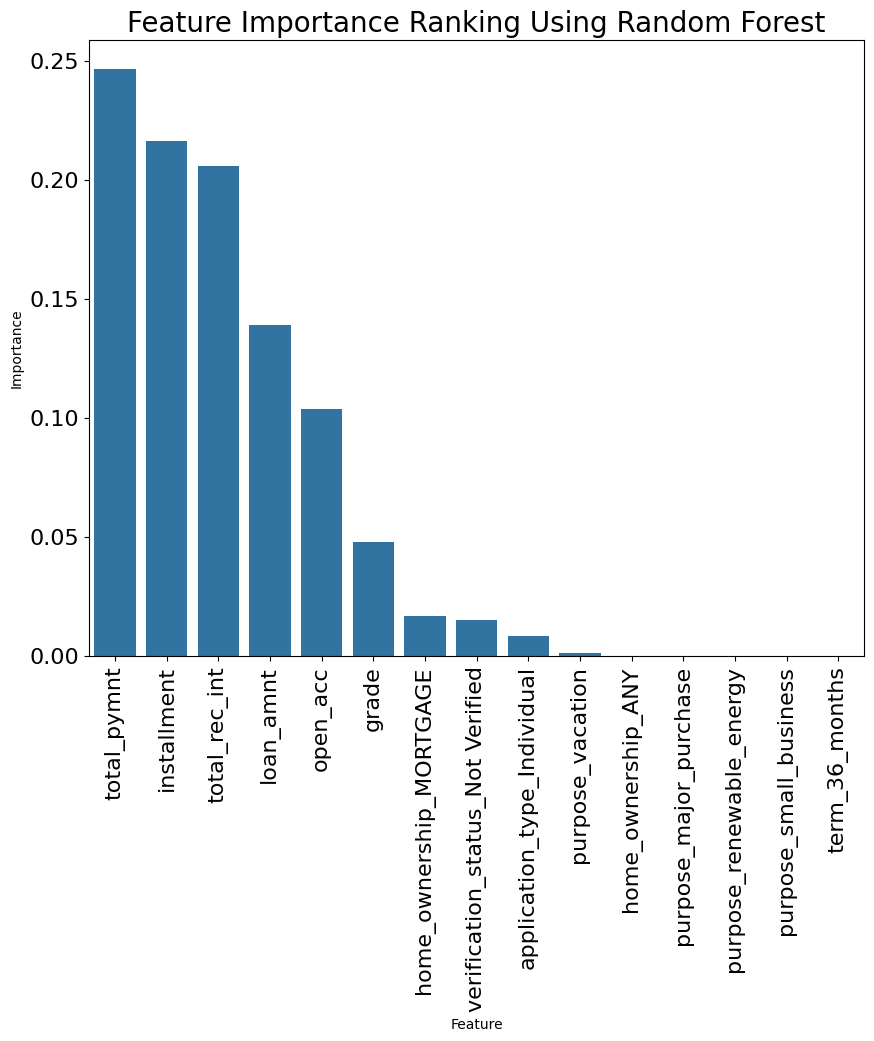

In [42]:
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder for encoding

# Step 1: Select only the specified 15 features and target variable
selected_columns = reduced_data.columns.tolist() + ['loan_status_encoded']

# Filter the dataset to keep only these columns (features + target)
data = df12[selected_columns]

# Step 2: Separate the features (X) and target (y)
X = data.drop('loan_status_encoded', axis=1)  # Features
y = data['loan_status_encoded']  # Target

# --- Encode categorical features ---
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate through columns in X to find and encode object (string) type columns
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col])

# Step 3: Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 5: Rank the feature importance
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 6: Visualize the feature importance
plt.figure(figsize=(10,8))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)
plt.title('Feature Importance Ranking Using Random Forest',fontsize=20)
plt.xticks(rotation=90, fontsize=16)  # Rotate x-axis labels and set font size
plt.yticks(fontsize=16) #Set y-axis labels font size
plt.show()

In [43]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Step 1: Select the target variable and features
# Assuming 'loan_status_encoded' is your target column
# Make sure you encode 'loan_status' to binary: 0 for normal, 1 for default
selected_columns = reduced_data.columns.tolist() + ['loan_status_encoded']

# Filter the dataset to keep only the selected columns (features + target)
data = data[selected_columns]

# Step 2: Separate the features (X) and target (y)
X = data.drop('loan_status_encoded', axis=1)  # Features
y = data['loan_status_encoded']  # Target

# Step 3: Split the dataset into train and test sets (optional, but recommended)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Step 4: Apply SMOTE to oversample the minority class in the training set
# Before applying SMOTE, impute missing values using SimpleImputer

# --- Impute Numerical Features ---
# Create a SimpleImputer for numerical features with strategy='mean'
num_imputer = SimpleImputer(strategy='mean')

# Get numerical features (assuming all non-object columns are numerical)
num_features = X_train.select_dtypes(exclude=['object']).columns

# Impute missing values in numerical features
X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
X_test[num_features] = num_imputer.transform(X_test[num_features])

# --- Impute Categorical Features ---
# Create a SimpleImputer for categorical features with strategy='most_frequent'
cat_imputer = SimpleImputer(strategy='most_frequent')

# Get categorical features (object type columns)
cat_features = X_train.select_dtypes(include=['object']).columns

# --- Encode Categorical Features ---
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Iterate through columns in X_train and X_test to find and encode object (string) type columns
for col in cat_features:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

X_train[num_features] = num_imputer.fit_transform(X_train[num_features]) # Fit and transform numerical features on training data
X_test[num_features] = num_imputer.transform(X_test[num_features]) #Transform test data's numerical features


# Step 5: Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 6: Display the class distribution before and after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

# Now you can use the resampled dataset (X_train_resampled, y_train_resampled) for modeling


Before SMOTE: loan_status_encoded
0    6800
1     200
Name: count, dtype: int64
After SMOTE: loan_status_encoded
0    6800
1    6800
Name: count, dtype: int64


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select the target variable and features
# Assuming 'loan_status_encoded' is your target column
# Make sure you encode 'loan_status' to binary: 0 for normal, 1 for default
# Select the 15 specified features and target variable (loan_status_encoded)
selected_columns = reduced_data.columns.tolist() + ['loan_status_encoded']

# Filter the dataset to keep only the selected columns (features + target)
data = data[selected_columns]

# Step 2: Separate the features (X) and target (y)
X = data.drop('loan_status_encoded', axis=1)  # Features
y = data['loan_status_encoded']  # Target


# Step 3: Split the resampled dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.3, random_state=42)

In [45]:
# Step 4: Train and Evaluate Models

# Model 1: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [46]:
# Model 2: Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [47]:
# Model 3: Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [48]:
# Model 4: Support Vector Machine (SVM)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [49]:
models = {
    'Random Forest': (y_pred_rf, rf),
    'Decision Tree': (y_pred_dt, dt),
    'Logistic Regression': (y_pred_lr, lr),
    'SVM': (y_pred_svm, svm)
}

results = []

for model_name, (y_pred, model) in models.items():

    report = classification_report(y_test, y_pred, target_names=['Normal (0)', 'Default (1)'], output_dict=True)

    accuracy = accuracy_score(y_test, y_pred)
    f1_negative = report['Normal (0)']['f1-score']
    recall_negative = report['Normal (0)']['recall']
    f1_positive = report['Default (1)']['f1-score']
    recall_positive = report['Default (1)']['recall']

    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test))

    results.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4)*100,
        'F1-Score Negative (0)': round(f1_negative, 4),
        'F1-Score Positive (1)': round(f1_positive, 4),
        'Recall Negative (0)': round(recall_negative, 4),
        'Recall Positive (1)': round(recall_positive, 4),
        'AUC-ROC': round(auc, 4)
    })

# Step 7: Display results in a DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-Score Negative (0),F1-Score Positive (1),Recall Negative (0),Recall Positive (1),AUC-ROC
0,Random Forest,98.68,0.9868,0.9867,0.9941,0.9794,0.9988
1,Decision Tree,96.99,0.9698,0.9699,0.9681,0.9716,0.9699
2,Logistic Regression,66.74,0.6832,0.6500,0.7179,0.6170,0.7391
3,SVM,66.03,0.6596,0.6610,0.6590,0.6616,0.7405


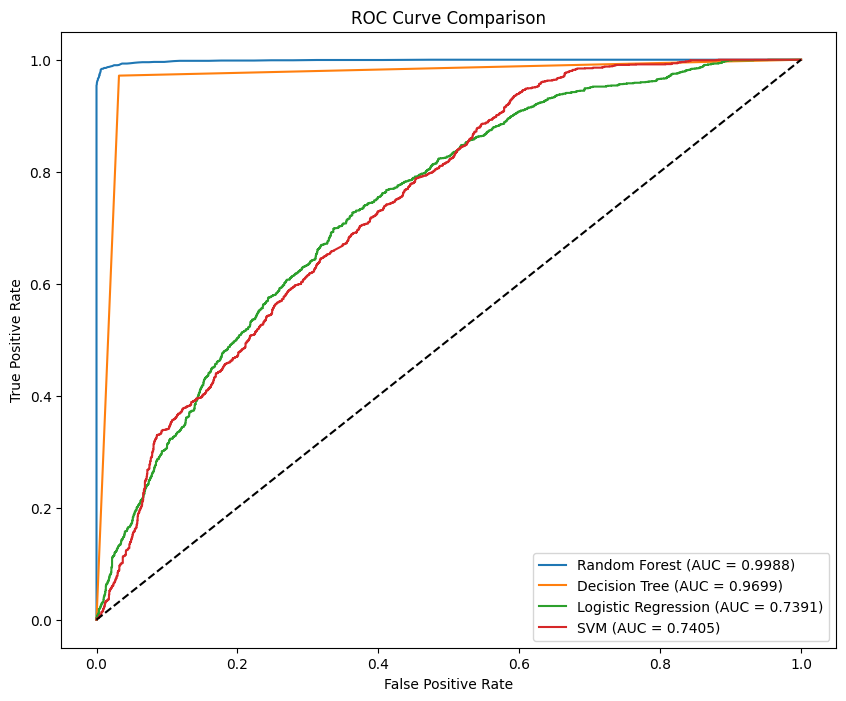

In [50]:
# Step 7: Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name, (y_pred, model) in models.items():
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    else:
        fpr, tpr, _ = roc_curve(y_test, model.decision_function(X_test))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)):.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# ***THE END OF OUR ANALYSIS*** 🥰

---